In [1]:
import pandas as pd

# Wczytanie danych
df = pd.read_csv("diabetes.csv")

# Pierwsze 5 wierszy
print("🔹 Pierwsze wiersze danych:")
print(df.head())

# Podstawowe informacje o kolumnach
print("\n🔹 Informacje o danych:")
print(df.info())

# Statystyki opisowe
print("\n🔹 Statystyki opisowe:")
print(df.describe())


🔹 Pierwsze wiersze danych:
   Pregnancies  Glucose  BloodPressure  ...  DiabetesPedigreeFunction  Age  Outcome
0            6      148             72  ...                     0.627   50        1
1            1       85             66  ...                     0.351   31        0
2            8      183             64  ...                     0.672   32        1
3            1       89             66  ...                     0.167   21        0
4            0      137             40  ...                     2.288   33        1

[5 rows x 9 columns]

🔹 Informacje o danych:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null 

In [2]:
# Lista kolumn, w których zero oznacza brak danych
cols_with_zeros = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]

for col in cols_with_zeros:
    zero_count = (df[col] == 0).sum()
    print(f"{col}: {zero_count} zer")


Glucose: 5 zer
BloodPressure: 35 zer
SkinThickness: 227 zer
Insulin: 374 zer
BMI: 11 zer


In [3]:
# Zamiana zer na medianę w wybranych kolumnach
for col in cols_with_zeros:
    median = df[col].median()
    df[col] = df[col].replace(0, median)

# Sprawdzenie czy jeszcze zostały zera
print((df[cols_with_zeros] == 0).sum())


Glucose          0
BloodPressure    0
SkinThickness    0
Insulin          0
BMI              0
dtype: int64


Outcome
0    500
1    268
Name: count, dtype: int64


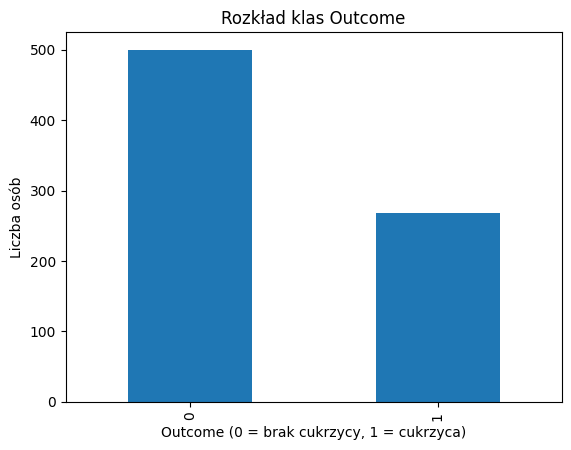

In [4]:
import matplotlib.pyplot as plt

# Policz wartości
outcome_counts = df["Outcome"].value_counts()
print(outcome_counts)

# Wykres słupkowy
outcome_counts.plot(kind="bar")
plt.title("Rozkład klas Outcome")
plt.xlabel("Outcome (0 = brak cukrzycy, 1 = cukrzyca)")
plt.ylabel("Liczba osób")
plt.show()


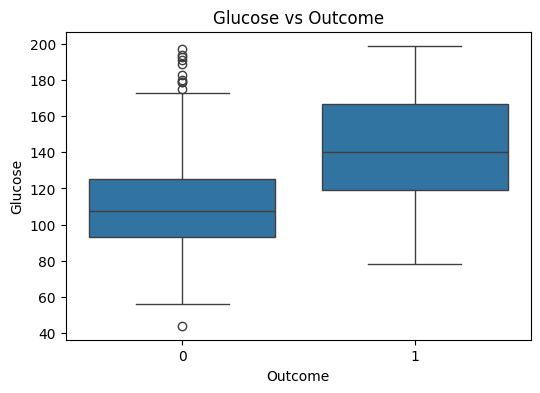

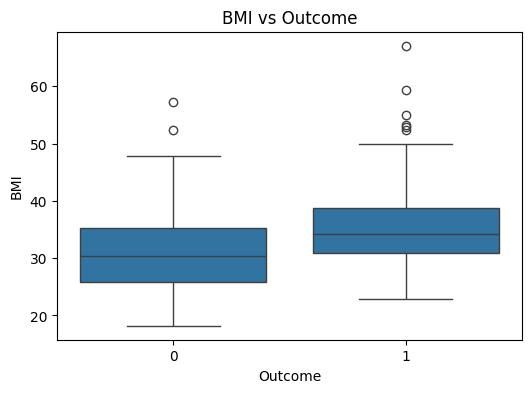

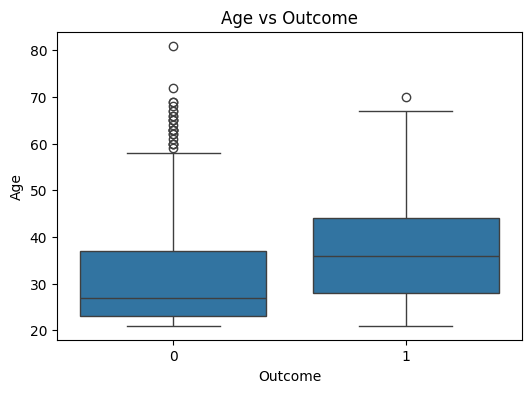

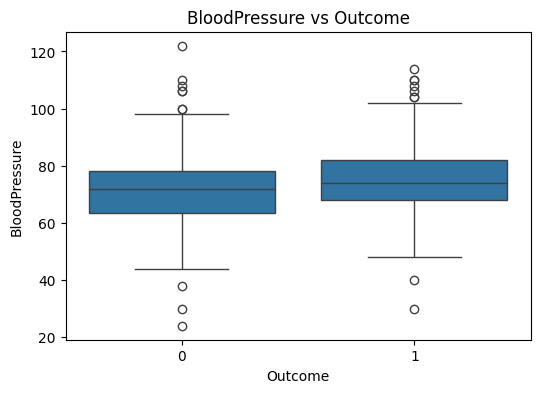

In [5]:
import seaborn as sns

features = ["Glucose", "BMI", "Age", "BloodPressure"]

for col in features:
    plt.figure(figsize=(6,4))
    sns.boxplot(x="Outcome", y=col, data=df)
    plt.title(f"{col} vs Outcome")
    plt.show()


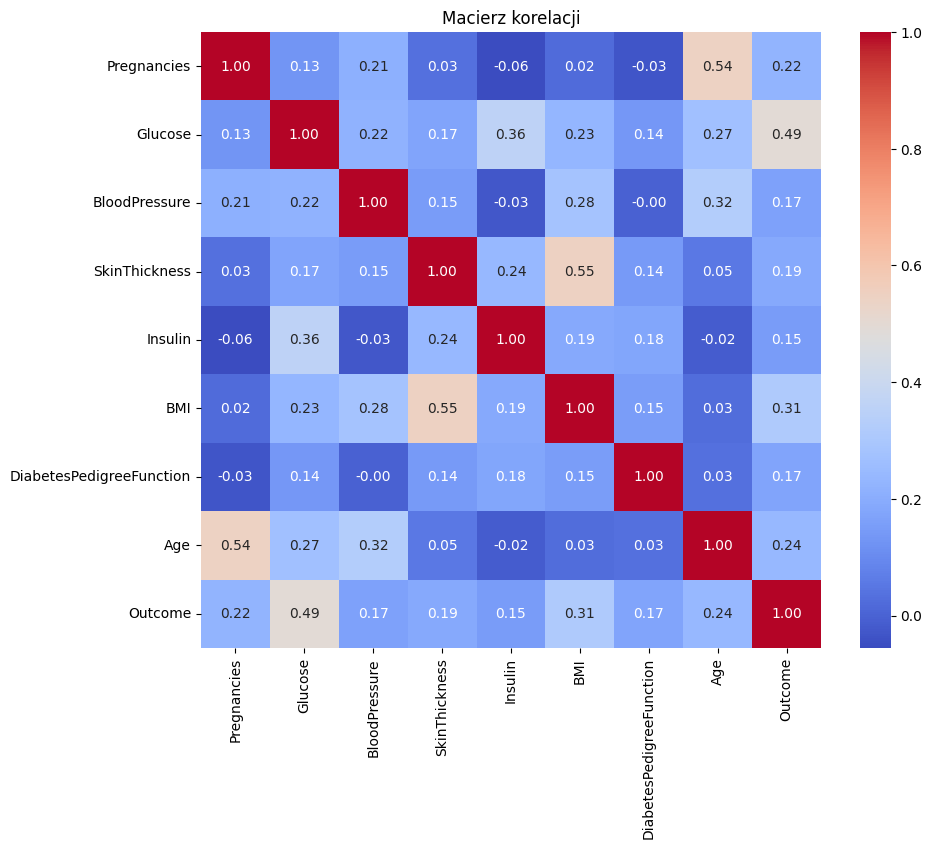

In [6]:
plt.figure(figsize=(10,8))
corr = df.corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Macierz korelacji")
plt.show()


In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv("diabetes.csv")

X = df.drop(columns="Outcome")
y = df["Outcome"]

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42)

print("Shapes:")
print(" X_train:", X_train.shape, " y_train:", y_train.shape)
print(" X_valid:", X_valid.shape, " y_valid:", y_valid.shape)
print(" X_test:", X_test.shape, " y_test:", y_test.shape)
print("\nRozkład klas (procenty):")
print(" train:\n", y_train.value_counts(normalize=True).round(3))
print(" valid:\n", y_valid.value_counts(normalize=True).round(3))
print(" test:\n", y_test.value_counts(normalize=True).round(3))

Shapes:
 X_train: (460, 8)  y_train: (460,)
 X_valid: (154, 8)  y_valid: (154,)
 X_test: (154, 8)  y_test: (154,)

Rozkład klas (procenty):
 train:
 Outcome
0    0.652
1    0.348
Name: proportion, dtype: float64
 valid:
 Outcome
0    0.649
1    0.351
Name: proportion, dtype: float64
 test:
 Outcome
0    0.649
1    0.351
Name: proportion, dtype: float64


In [8]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif
import pandas as pd
import numpy as np

zero_as_missing = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]
other_cols = [col for col in X_train.columns if col not in zero_as_missing]

preprocessor = ColumnTransformer(
    transformers=[
        ("impute_zero", SimpleImputer(missing_values=0, strategy="median"), zero_as_missing),
        ("pass", "passthrough", other_cols)
    ],
    remainder="drop",
    verbose_feature_names_out=False
)

pipeline = Pipeline(steps=[
    ("prep", preprocessor),
    ("scale", StandardScaler()),
    ("select", SelectKBest(score_func=f_classif, k="all"))
])

pipeline.fit(X_train, y_train)

feature_names = pipeline.named_steps["prep"].get_feature_names_out()
scores = pipeline.named_steps["select"].scores_
ranking = pd.DataFrame({"feature": feature_names, "f_score": scores}).sort_values("f_score", ascending=False)
print(ranking.to_string(index=False))

                 feature    f_score
                 Glucose 150.907345
                     BMI  57.849952
                 Insulin  24.126730
                     Age  22.523051
           SkinThickness  20.701812
DiabetesPedigreeFunction  15.739661
             Pregnancies  15.709417
           BloodPressure  11.474021


In [9]:
pipeline_final = Pipeline(steps=[
    ("prep", preprocessor),
    ("scale", StandardScaler()),
    ("select", SelectKBest(score_func=f_classif, k=5))
])

pipeline_final.fit(X_train, y_train)

X_train_sel = pipeline_final.transform(X_train)
X_valid_sel = pipeline_final.transform(X_valid)
X_test_sel = pipeline_final.transform(X_test)

selected_features = pipeline_final.named_steps["select"].get_feature_names_out(pipeline_final.named_steps["prep"].get_feature_names_out())
print("Wybrane cechy:" , selected_features)
print("X_train_sel shape:", X_train_sel.shape)

Wybrane cechy: ['Glucose' 'SkinThickness' 'Insulin' 'BMI' 'Age']
X_train_sel shape: (460, 5)


In [10]:
train_out = pd.DataFrame(X_train_sel, columns=selected_features)
train_out["Outcome"] = y_train.to_numpy()

valid_out = pd.DataFrame(X_valid_sel, columns=selected_features)
valid_out["Outcome"] = y_valid.to_numpy()

test_out = pd.DataFrame(X_test_sel, columns=selected_features)
test_out["Outcome"] = y_test.to_numpy()

train_out.to_csv("train_prepared.csv", index=False)
valid_out.to_csv("valid_prepared.csv", index=False)
test_out.to_csv("test_prepared.csv", index=False)

print("Dane zostały przygotowane i zapisane do plików CSV.")

Dane zostały przygotowane i zapisane do plików CSV.


In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

# end-to-end: preprocessing (Twój pipeline_final) + LogisticRegression
full_pipe = Pipeline(steps=pipeline_final.steps + [
    ("clf", LogisticRegression(
        max_iter=1000,
        solver="liblinear",     # stabilny przy małej liczbie cech
        class_weight="balanced",# koryguje lekką nierównowagę 0/1
        random_state=42
    ))
])

# Trenujemy WYŁĄCZNIE na train
full_pipe.fit(X_train, y_train)
print("Gotowe: model bazowy dopasowany na train.")


Gotowe: model bazowy dopasowany na train.


In [12]:
from sklearn.metrics import (
    roc_auc_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_curve
)
import numpy as np
import pandas as pd

def evaluate(pipe, X, y, name="valid", threshold=0.5):
    proba = pipe.predict_proba(X)[:, 1]
    auc = roc_auc_score(y, proba)
    y_pred = (proba >= threshold).astype(int)
    prec = precision_score(y, y_pred, zero_division=0)
    rec  = recall_score(y, y_pred, zero_division=0)
    f1   = f1_score(y, y_pred, zero_division=0)
    cm   = confusion_matrix(y, y_pred)

    print(f"\n=== {name.upper()} @ thr={threshold:.2f} ===")
    print(f"ROC AUC  : {auc:.3f}")
    print(f"Precision: {prec:.3f}")
    print(f"Recall   : {rec:.3f}")
    print(f"F1       : {f1:.3f}")
    print("Confusion matrix:\n", cm)
    return {"roc_auc": auc, "precision": prec, "recall": rec, "f1": f1}, proba


In [13]:
metrics_valid_05, proba_valid = evaluate(full_pipe, X_valid, y_valid, name="valid", threshold=0.5)



=== VALID @ thr=0.50 ===
ROC AUC  : 0.850
Precision: 0.621
Recall   : 0.759
F1       : 0.683
Confusion matrix:
 [[75 25]
 [13 41]]


In [14]:
# Krzywa ROC + progi
fpr, tpr, thr = roc_curve(y_valid, proba_valid)

# 1) Najlepszy próg wg Youden's J
youden_ix = np.argmax(tpr - fpr)
thr_youden = thr[youden_ix]
print("Najlepszy próg (Youden):", round(float(thr_youden), 4))
metrics_valid_youden, _ = evaluate(full_pipe, X_valid, y_valid, name="valid-YOUDEN", threshold=thr_youden)

# 2) Najlepszy próg dla F1 (przeskanujemy kandydatów)
cands = np.unique(np.r_[thr, [0.5]])  # dorzuć 0.5 dla pewności
best_f1, thr_f1 = -1, 0.5
for t in cands:
    y_pred = (proba_valid >= t).astype(int)
    f1 = f1_score(y_valid, y_pred, zero_division=0)
    if f1 > best_f1:
        best_f1, thr_f1 = f1, t

print("Najlepszy próg (max F1):", round(float(thr_f1), 4))
metrics_valid_f1, _ = evaluate(full_pipe, X_valid, y_valid, name="valid-maxF1", threshold=thr_f1)


Najlepszy próg (Youden): 0.6281

=== VALID-YOUDEN @ thr=0.63 ===
ROC AUC  : 0.850
Precision: 0.750
Recall   : 0.667
F1       : 0.706
Confusion matrix:
 [[88 12]
 [18 36]]
Najlepszy próg (max F1): 0.6281

=== VALID-MAXF1 @ thr=0.63 ===
ROC AUC  : 0.850
Precision: 0.750
Recall   : 0.667
F1       : 0.706
Confusion matrix:
 [[88 12]
 [18 36]]


In [15]:
THR = thr_f1  # <- podmień na wybrany próg: thr_youden lub thr_f1
metrics_test, proba_test = evaluate(full_pipe, X_test, y_test, name="test", threshold=THR)



=== TEST @ thr=0.63 ===
ROC AUC  : 0.788
Precision: 0.608
Recall   : 0.574
F1       : 0.590
Confusion matrix:
 [[80 20]
 [23 31]]


In [16]:
import json, joblib

# 1) Zapisz model end-to-end (preproc + selekcja + logreg)
joblib.dump(full_pipe, "logreg_baseline.joblib")

# 2) Zapisz metryki
out = {
    "valid@0.5": metrics_valid_05,
    "valid@youden": metrics_valid_youden,
    "valid@maxF1": metrics_valid_f1,
    "test@THR": metrics_test,
    "threshold_selected": float(THR)
}
with open("metrics_logreg.json", "w") as f:
    json.dump(out, f, indent=2)

# 3) Zapisz punkty ROC dla walidacji (przydadzą się do wykresu)
roc_df = pd.DataFrame({"fpr": fpr, "tpr": tpr, "threshold": thr})
roc_df.to_csv("roc_valid.csv", index=False)

# 4) (opcjonalnie) Zapis predykcji z walidacji/testu
pd.DataFrame({"y_true": y_valid.to_numpy(), "proba": proba_valid}).to_csv("valid_predictions.csv", index=False)
pd.DataFrame({"y_true": y_test.to_numpy(),  "proba": proba_test}).to_csv("test_predictions.csv",  index=False)

print("Zapisano: logreg_baseline.joblib, metrics_logreg.json, roc_valid.csv, valid_predictions.csv, test_predictions.csv")


Zapisano: logreg_baseline.joblib, metrics_logreg.json, roc_valid.csv, valid_predictions.csv, test_predictions.csv


In [17]:
THR = 0.63  # próg wybrany z walidacji
metrics_test, proba_test = evaluate(full_pipe, X_test, y_test, name="test", threshold=THR)



=== TEST @ thr=0.63 ===
ROC AUC  : 0.788
Precision: 0.620
Recall   : 0.574
F1       : 0.596
Confusion matrix:
 [[81 19]
 [23 31]]


In [18]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, roc_curve

proba_valid = full_pipe.predict_proba(X_valid)[:, 1]

thresholds = np.round(np.linspace(0.05, 0.95, 91), 3)

rows = []
for t in thresholds:
    y_pred = (proba_valid >= t).astype(int)
    rows.append({
        "threshold": float(t),
        "roc_auc": roc_auc_score(y_valid, proba_valid),
        "precision": precision_score(y_valid, y_pred, zero_division=0),
        "recall": recall_score(y_valid, y_pred, zero_division=0),
        "f1": f1_score(y_valid, y_pred, zero_division=0),
    })
thr_table = pd.DataFrame(rows)

youden_fpr, youden_tpr, youden_thr = roc_curve(y_valid, proba_valid)
thr_youden = float(youden_thr[np.argmax(youden_tpr - youden_fpr)])
thr_maxf1 = float(thr_table.loc[thr_table['f1'].idxmax(), 'threshold'])

print(f"Optimal thresholds - Youden: {round(thr_youden, 4)}, Max F1: {round(thr_maxf1, 4)}")

display_cols = ['threshold', 'precision', 'recall', 'f1']
print("\nTOP 10 wg F1:")
print(thr_table.sort_values('f1', ascending=False)[display_cols].head(10).to_string(index=False))

thr_table.to_csv("validation_threshold_sweep.csv", index=False)
print("\nZapisano wyniki do pliku validation_threshold_sweep.csv")  

Optimal thresholds - Youden: 0.6281, Max F1: 0.64

TOP 10 wg F1:
 threshold  precision   recall       f1
      0.64   0.760870 0.648148 0.700000
      0.63   0.744681 0.648148 0.693069
      0.62   0.720000 0.666667 0.692308
      0.33   0.564706 0.888889 0.690647
      0.51   0.630769 0.759259 0.689076
      0.70   0.820513 0.592593 0.688172
      0.68   0.785714 0.611111 0.687500
      0.65   0.755556 0.629630 0.686869
      0.32   0.558140 0.888889 0.685714
      0.50   0.621212 0.759259 0.683333

Zapisano wyniki do pliku validation_threshold_sweep.csv


In [19]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, roc_curve
import numpy as np
import pandas as pd

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

oof_proba = np.zeros(len(X_train))
fold_metrics = []
fold_thr_youden = []
fold_thr_maxf1 = []

for fold, (tr_idx, va_idx) in enumerate(cv.split(X_train, y_train), 1):
    X_tr, X_va = X_train.iloc[tr_idx], X_train.iloc[va_idx]
    y_tr, y_va = y_train.iloc[tr_idx], y_train.iloc[va_idx]

    model = clone(full_pipe)
    model.fit(X_tr, y_tr)
    proba_va = model.predict_proba(X_va)[:, 1]
    oof_proba[va_idx] = proba_va

    fpr, tpr, thr = roc_curve(y_va, proba_va)
    t_youden = float(thr[np.argmax(tpr - fpr)])
    cand_thr = np.unique(np.r_[thr, np.linspace(0.05, 0.95, 91)])  
    best_f1, best_t = -1, 0.5
    for t in cand_thr:
        y_pred = (proba_va >= t).astype(int)
        f1 = f1_score(y_va, y_pred, zero_division=0)
        if f1 > best_f1:
            best_f1, best_t = f1, float(t)

    fold_thr_youden.append(t_youden)
    fold_thr_maxf1.append(best_t)
    
    y_pred_05 = (proba_va >= 0.5).astype(int)
    fold_metrics.append({
        "fold": fold,
        "auc": roc_auc_score(y_va, proba_va),
        "precision@0.5": precision_score(y_va, y_pred_05, zero_division=0),
        "recall@0.5": recall_score(y_va, y_pred_05, zero_division=0),
        "f1@0.5": f1_score(y_va, y_pred_05, zero_division=0),
        "thr_youden": t_youden,
        "thr_maxf1": best_t,
    })

cv_df = pd.DataFrame(fold_metrics)
print("Wyniki 5-fold (fold-wise):")
print(cv_df.round(3).to_string(index=False))

print("\nŚrednie (±std):")
print("AUC         :", f"{cv_df['auc'].mean():.3f} ± {cv_df['auc'].std():.3f}")
print("Precision@0.5:", f"{cv_df['precision@0.5'].mean():.3f} ± {cv_df['precision@0.5'].std():.3f}")
print("Recall@0.5   :", f"{cv_df['recall@0.5'].mean():.3f} ± {cv_df['recall@0.5'].std():.3f}")
print("F1@0.5       :", f"{cv_df['f1@0.5'].mean():.3f} ± {cv_df['f1@0.5'].std():.3f}")

thr_cv_youden = float(np.median(fold_thr_youden))
thr_cv_maxf1  = float(np.median(fold_thr_maxf1))
print("\nStabilne progi (median z foldów):")
print("  • Youden :", round(thr_cv_youden, 4))
print("  • max F1 :", round(thr_cv_maxf1, 4))

# Zapis (opcjonalnie)
cv_df.to_csv("cv5_train_oof_metrics.csv", index=False)
print("\nZapisano: cv5_train_oof_metrics.csv")


Wyniki 5-fold (fold-wise):
 fold   auc  precision@0.5  recall@0.5  f1@0.5  thr_youden  thr_maxf1
    1 0.845          0.657       0.719   0.687       0.552      0.552
    2 0.839          0.667       0.688   0.677       0.648      0.590
    3 0.810          0.600       0.656   0.627       0.434      0.420
    4 0.810          0.548       0.719   0.622       0.425      0.420
    5 0.796          0.679       0.594   0.633       0.478      0.470

Średnie (±std):
AUC         : 0.820 ± 0.021
Precision@0.5: 0.630 ± 0.055
Recall@0.5   : 0.675 ± 0.052
F1@0.5       : 0.649 ± 0.030

Stabilne progi (median z foldów):
  • Youden : 0.4777
  • max F1 : 0.47

Zapisano: cv5_train_oof_metrics.csv


In [26]:
import json, joblib
from sklearn.metrics import confusion_matrix

THR = 0.47  # <- podmień na wybrany próg (np. z Krok 1 lub thr_cv_maxf1)

# Ewaluacja na teście
proba_test = full_pipe.predict_proba(X_test)[:, 1]
y_pred_test = (proba_test >= THR).astype(int)

metrics_test = {
    "roc_auc": roc_auc_score(y_test, proba_test),
    "precision": precision_score(y_test, y_pred_test, zero_division=0),
    "recall": recall_score(y_test, y_pred_test, zero_division=0),
    "f1": f1_score(y_test, y_pred_test, zero_division=0),
    "confusion_matrix": confusion_matrix(y_test, y_pred_test).tolist(),
    "threshold": float(THR)
}
print("\nTEST @ thr=", THR)
print(metrics_test)

# Zapis modelu i metryk
joblib.dump(full_pipe, "logreg_baseline.joblib")
with open("threshold_and_metrics.json", "w") as f:
    json.dump(metrics_test, f, indent=2)

print("\nZapisano: logreg_baseline.joblib, threshold_and_metrics.json")



TEST @ thr= 0.47
{'roc_auc': np.float64(0.7877777777777778), 'precision': 0.5606060606060606, 'recall': 0.6851851851851852, 'f1': 0.6166666666666667, 'confusion_matrix': [[71, 29], [17, 37]], 'threshold': 0.47}

Zapisano: logreg_baseline.joblib, threshold_and_metrics.json
